<a href="https://colab.research.google.com/github/ever-oli/MLby22/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading PaySim dataset via Hugging Face mirror...


README.md: 0.00B [00:00, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-1-(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-10(…):   0%|          | 0.00/127M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-11(…):   0%|          | 0.00/127M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-12(…):   0%|          | 0.00/127M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-13(…):   0%|          | 0.00/127M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-14(…):   0%|          | 0.00/127M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-2-(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-3-(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-4-(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-5-(…):   0%|          | 0.00/131M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-6-(…):   0%|          | 0.00/131M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-7-(…):   0%|          | 0.00/131M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-8-(…):   0%|          | 0.00/131M [00:00<?, ?B/s]

Cifer-Fraud-Detection-Dataset-AF-part-9-(…):   0%|          | 0.00/127M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/21000000 [00:00<?, ? examples/s]

Shape after isolating threat vectors: (9152414, 11)
Applying financial feature engineering...
Splitting data...
Training LightGBM Classifier natively on imbalanced data...
[LightGBM] [Info] Number of positive: 9572, number of negative: 7312359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 7321931, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001307 -> initscore=-6.638479
[LightGBM] [Info] Start training from score -6.638479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

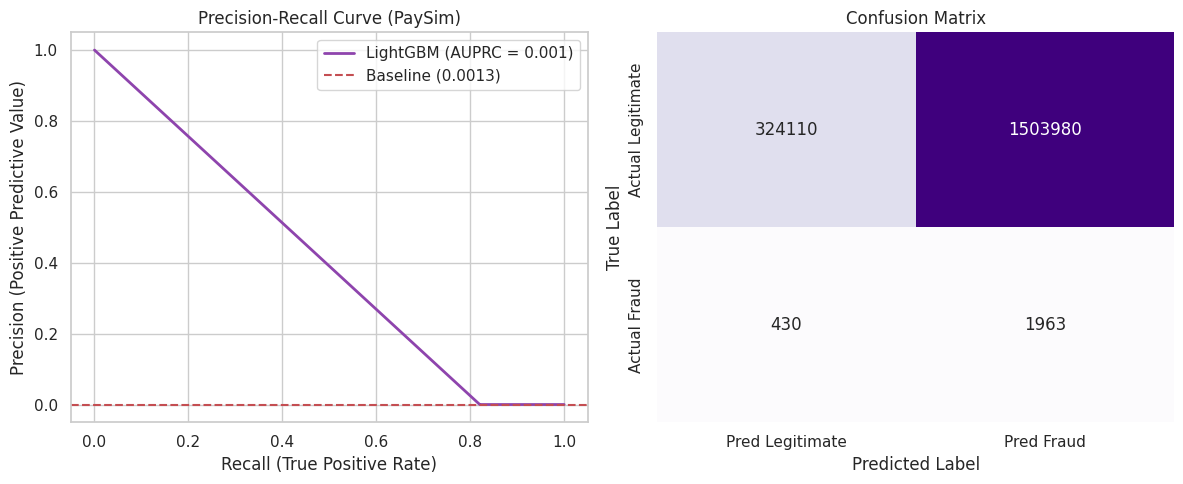

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")

# 1. Data Ingestion
print("Loading PaySim dataset via Hugging Face mirror...")
dataset = load_dataset("CiferAI/Cifer-Fraud-Detection-Dataset-AF", split="train")
df = dataset.to_pandas()

# 2. Domain-Specific Filtering
valid_types = ['TRANSFER', 'CASH_OUT']
df = df.loc[df['type'].isin(valid_types)]
print(f"Shape after isolating threat vectors: {df.shape}")

# 3. Financial Feature Engineering
print("Applying financial feature engineering...")
cols_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True, errors='ignore')

# Exact accounting footprints (DO NOT SCALE THESE LATER)
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

df['Log_Amount'] = np.log1p(df['amount'])
df.drop('amount', axis=1, inplace=True)

if 'step' in df.columns:
    df['HourOfDay'] = df['step'] % 24
    df['Hour_Sin'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
    df['Hour_Cos'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)
    df.drop(['step', 'HourOfDay'], axis=1, inplace=True)

df = pd.get_dummies(df, drop_first=True)

# 4. Train/Test Split
print("Splitting data...")
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Notice: NO SMOTE AND NO STANDARD SCALER. We pass the raw math directly to the trees.

# 5. Model Training (LightGBM with is_unbalance)
print("Training LightGBM Classifier natively on imbalanced data...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    is_unbalance=True, # This tells LightGBM to automatically weight the 0.13% fraud class heavily
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)

# 6. Evaluation and AUPRC
print("\nEvaluating model on the pristine test set...")
y_pred = lgb_model.predict(X_test)
y_prob = lgb_model.predict_proba(X_test)[:, 1]

auprc = average_precision_score(y_test, y_prob)

print("\n" + "=" * 45)
print("PAYSIM FRAUD DETECTION METRICS")
print("=" * 45)
print(f"Area Under Precision-Recall Curve (AUPRC): {auprc:.4f}")
print("-" * 45)
print(classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Fraud (1)']))

# 7. Visualizations
plt.figure(figsize=(12, 5))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='#8e44ad', lw=2, label=f'LightGBM (AUPRC = {auprc:.3f})')
baseline = y_test.mean()
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline ({baseline:.4f})')
plt.title('Precision-Recall Curve (PaySim)')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.legend(loc="upper right")

# Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Pred Legitimate', 'Pred Fraud'],
            yticklabels=['Actual Legitimate', 'Actual Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()